# About this notebook  

TBD...

In [1]:
import os

if os.environ.get("KAGGLE_KERNEL_RUN_TYPE") is None:
    ON_KAGGLE = False
else:
    ON_KAGGLE = True

# Data Loading

In [2]:
import os

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
os.listdir("../input/cassava-leaf-disease-classification")

['label_num_to_disease_map.json',
 'sample_submission.csv',
 'train_tfrecords',
 'test_tfrecords',
 'test_images',
 'train_images',
 'train.csv']

In [4]:
# train = pd.read_csv("../input/cassava-leaf-disease-classification/train.csv")
train = pd.read_csv("../input/cassava-leaf-disease-merged/merged.csv")
test = pd.read_csv("../input/cassava-leaf-disease-classification/sample_submission.csv")
label_map = pd.read_json("../input/cassava-leaf-disease-classification/label_num_to_disease_map.json", orient="index")
display(train.head())
display(test.head())
display(label_map)

,image_id,label,source
0,1000015157.jpg,0,2020
1,1000201771.jpg,3,2020
2,100042118.jpg,1,2020
3,1000723321.jpg,1,2020
4,1000812911.jpg,3,2020


,image_id,label
0,2216849948.jpg,4


,0
0,Cassava Bacterial Blight (CBB)
1,Cassava Brown Streak Disease (CBSD)
2,Cassava Green Mottle (CGM)
3,Cassava Mosaic Disease (CMD)
4,Healthy


/home/ubuntu/work/pytorch/.venv/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='label'>

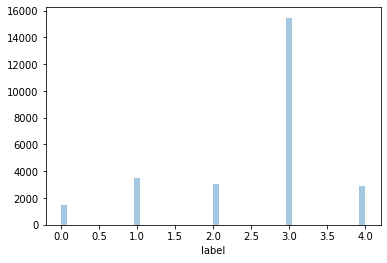

In [5]:
sns.distplot(train["label"], kde=False)

# Directory settings

In [6]:
# ====================================================
# Directory settings
# ====================================================
import os

OUTPUT_DIR = "./"
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# TRAIN_PATH = "../input/cassava-leaf-disease-classification/train_images"
TRAIN_PATH = "../input/cassava-leaf-disease-merged/train"
TEST_PATH = "../input/cassava-leaf-disease-classification/test_images"

# CFG

In [7]:
# ====================================================
# CFG
# ====================================================
class CFG:
    debug = False
    apex = False
    print_freq = 100
    num_workers = 4
    model_name = (
        "tf_efficientnet_b4_ns"  # resnext50_32x4d, tf_efficientnet_b3_ns, tf_efficientnet_b4_ns, vit_base_patch16_384
    )
    size = 384 if model_name.startswith("vit_base_") else 512  # 512 if ON_KAGGLE else 384
    criterion = "BiTemperedLoss"  # ['CrossEntropyLoss', 'BiTemperedLoss']
    btl_t1 = 0.3  # Bi-Tempered Logistic Loss
    btl_t2 = 1.0
    label_smoothing = 0.05
    scheduler = (
        "CosineAnnealingWarmRestarts"  # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts']
    )
    epochs = 10
    # factor=0.2 # ReduceLROnPlateau
    # patience=4 # ReduceLROnPlateau
    # eps=1e-6 # ReduceLROnPlateau
    # T_max=10 # CosineAnnealingLR
    T_0 = 10  # CosineAnnealingWarmRestarts
    lr = 1e-4
    min_lr = 1e-6
    batch_size = 8  # resnext50_32x4d: 14, tf_efficientnet_b3_ns:10, tf_efficientnet_b4_ns: 8
    weight_decay = 1e-6
    gradient_accumulation_steps = 1
    max_grad_norm = 1000
    seed = 222
    target_size = 5
    target_col = "label"
    n_fold = 5
    trn_fold = [0, 1, 2, 3, 4]
    train = True
    inference = False


if CFG.debug:
    CFG.epochs = 1
    train = train.sample(n=1000, random_state=CFG.seed).reset_index(drop=True)

# Library

In [8]:
# ====================================================
# Library
# ====================================================
import sys

sys.path.append("../input/pytorch-image-models/pytorch-image-models-master")
sys.path.append("../input/bitemperedlogloss/")
sys.path.append("../input/image-fmix/FMix-master")

import math
import os
import random
import shutil
import time
import warnings
from collections import Counter, defaultdict
from contextlib import contextmanager
from functools import partial
from pathlib import Path

import bi_tempered_loss_pytorch as btl
import cv2
import numpy as np
import pandas as pd
import scipy as sp
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from albumentations import (
    CoarseDropout,
    Compose,
    Cutout,
    HorizontalFlip,
    HueSaturationValue,
    IAAAdditiveGaussianNoise,
    ImageOnlyTransform,
    Normalize,
    OneOf,
    RandomBrightness,
    RandomBrightnessContrast,
    RandomContrast,
    RandomCrop,
    RandomResizedCrop,
    Resize,
    Rotate,
    ShiftScaleRotate,
    Transpose,
    VerticalFlip,
)
from albumentations.pytorch import ToTensorV2
from fmix import sample_mask
from PIL import Image
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from torch.nn.parameter import Parameter
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")

if CFG.apex:
    from apex import amp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Utils

In [9]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)


@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f"[{name}] start")
    yield
    LOGGER.info(f"[{name}] done in {time.time() - t0:.0f} s.")


def init_logger(log_file=OUTPUT_DIR + "train.log"):
    from logging import INFO, FileHandler, Formatter, StreamHandler, getLogger

    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_torch(seed=CFG.seed)

# CV split

In [10]:
folds = train.copy()
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[CFG.target_col])):
    folds.loc[val_index, "fold"] = int(n)
folds["fold"] = folds["fold"].astype(int)
print(folds.groupby(["fold", CFG.target_col]).size())

fold  label
0     0         299
      1         695
      2         604
      3        3092
      4         578
1     0         299
      1         695
      2         604
      3        3092
      4         578
2     0         298
      1         695
      2         603
      3        3093
      4         578
3     0         298
      1         695
      2         603
      3        3093
      4         578
4     0         298
      1         696
      2         603
      3        3092
      4         578
dtype: int64


# Dataset

In [11]:
# ====================================================
# Dataset
# ====================================================
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df["image_id"].values
        self.labels = df["label"].values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f"{TRAIN_PATH}/{file_name}"
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
        label = torch.tensor(self.labels[idx]).long()
        return image, label


class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df["image_id"].values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f"{TEST_PATH}/{file_name}"
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
        return image

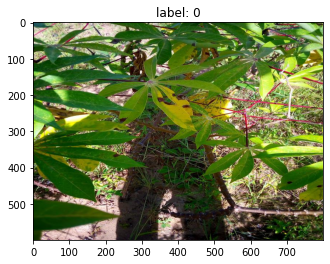

In [12]:
train_dataset = TrainDataset(train, transform=None)

for i in range(1):
    image, label = train_dataset[i]
    plt.imshow(image)
    plt.title(f"label: {label}")
    plt.show()

# Transforms

In [13]:
# ====================================================
# Transforms
# ====================================================
def get_transforms(*, data):

    if data == "train":
        return Compose(
            [
                # Resize(CFG.size, CFG.size),
                RandomResizedCrop(CFG.size, CFG.size),
                Transpose(p=0.5),
                HorizontalFlip(p=0.5),
                VerticalFlip(p=0.5),
                ShiftScaleRotate(p=0.5),
                HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
                RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
                CoarseDropout(p=0.5),
                Cutout(p=0.5),
                Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                ),
                ToTensorV2(),
            ]
        )

    elif data == "valid":
        return Compose(
            [
                Resize(CFG.size, CFG.size),
                Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                ),
                ToTensorV2(),
            ]
        )

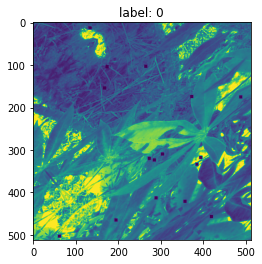

In [14]:
train_dataset = TrainDataset(train, transform=get_transforms(data="train"))

for i in range(1):
    image, label = train_dataset[i]
    plt.imshow(image[0])
    plt.title(f"label: {label}")
    plt.show()

# CutMix / FMix


In [15]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1.0 - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2


def cutmix(data, target, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_target = target[indices]

    lam = np.clip(np.random.beta(alpha, alpha), 0.3, 0.4)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    new_data = data.clone()
    new_data[:, :, bby1:bby2, bbx1:bbx2] = data[indices, :, bby1:bby2, bbx1:bbx2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))
    targets = (target, shuffled_target, lam)

    return new_data, targets


def fmix(data, targets, alpha, decay_power, shape, max_soft=0.0, reformulate=False):
    lam, mask = sample_mask(alpha, decay_power, shape, max_soft, reformulate)
    # mask =torch.tensor(mask, device=device).float()
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]
    x1 = torch.from_numpy(mask).to(device) * data
    x2 = torch.from_numpy(1 - mask).to(device) * shuffled_data
    targets = (targets, shuffled_targets, lam)

    return (x1 + x2), targets

# MODEL

In [16]:
# ====================================================
# MODEL
# ====================================================
class CassvaImgClassifier(nn.Module):
    def __init__(self, model_name="resnext50_32x4d", pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)

        if model_name == "resnext50_32x4d":
            n_features = self.model.fc.in_features
            self.model.fc = nn.Linear(n_features, CFG.target_size)

        elif model_name.startswith("tf_efficientnet"):
            n_features = self.model.classifier.in_features
            self.model.classifier = nn.Linear(n_features, CFG.target_size)

        elif model_name.startswith("vit_base_"):
            n_features = self.model.head.in_features
            self.model.head = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x

In [17]:
def freeze_batch_normalization(model):
    if CFG.model_name.startswith("tf_efficientnet_"):
        for name1, child1 in model.named_children():
            for name2, child2 in child1.named_children():
                # print(f"===== {name2} =====")
                if name2.startswith("bn"):
                    for param in child2.parameters():
                        param.requires_grad = False
                        # print(param.requires_grad)

                for child3 in child2.children():
                    if isinstance(child3, nn.modules.container.Sequential):
                        for child4 in child3.children():
                            for child5 in child4.children():
                                if isinstance(child5, nn.BatchNorm2d):
                                    # print(child5)
                                    for param in child5.parameters():
                                        param.requires_grad = False
                                        # print(param.requires_grad)

    elif CFG.model_name.startswith("resnext50_32x4d"):
        for name1, child1 in model.named_children():
            for name2, child2 in child1.named_children():
                # print(f"===== {name2}: {type(child2)} =====")
                if name2.startswith("bn"):
                    for param in child2.parameters():
                        param.requires_grad = False
                        # print(param.requires_grad)

                if isinstance(child2, nn.modules.container.Sequential):
                    for child3 in child2.children():
                        for child4 in child3.children():
                            if isinstance(child4, nn.BatchNorm2d):
                                # print(child4)
                                for param in child4.parameters():
                                    param.requires_grad = False
                                    # print(param.requires_grad)

In [18]:
model = CassvaImgClassifier(model_name=CFG.model_name, pretrained=False)
freeze_batch_normalization(model)

train_dataset = TrainDataset(train, transform=get_transforms(data="train"))
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)

for image, label in train_loader:
    output = model(image)
    print(output)
    break

tensor([[-0.0993,  0.1182, -0.0028, -0.0361, -0.0519],
        [-0.1160,  0.0981,  0.0185, -0.0298, -0.0518],
        [-0.0932,  0.1004, -0.0166, -0.0067, -0.0889],
        [-0.1934,  0.1112,  0.2745,  0.2732, -0.4664]],
       grad_fn=<AddmmBackward>)


# Loss functions

In [19]:
class BiTemperedLogisticLoss(nn.Module):
    def __init__(self, t1, t2, smoothing=0.0):
        super(BiTemperedLogisticLoss, self).__init__()
        self.t1 = t1
        self.t2 = t2
        self.smoothing = smoothing

    def forward(self, logit_label, truth_label):
        loss_label = btl.bi_tempered_logistic_loss(
            logit_label, truth_label, t1=self.t1, t2=self.t2, label_smoothing=self.smoothing, reduction="none"
        )

        loss_label = loss_label.mean()
        return loss_label

# Helper functions

In [20]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return "%s (remain %s)" % (asMinutes(s), asMinutes(rs))


def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        # CutMix, FMix
        mix_decision = np.random.rand()
        if mix_decision < 0.25:
            images, labels = cutmix(images, labels, 1.0)
        elif mix_decision >= 0.25 and mix_decision < 0.5:
            images, labels = fmix(images, labels, alpha=1.0, decay_power=5.0, shape=(CFG.size, CFG.size))

        y_preds = model(images.float())

        if mix_decision < 0.50:
            loss = criterion(y_preds, labels[0]) * labels[2] + criterion(y_preds, labels[1]) * (1.0 - labels[2])
        else:
            loss = criterion(y_preds, labels)

        # record loss
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        if CFG.apex:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
        else:
            loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader) - 1):
            print(
                "Epoch: [{0}][{1}/{2}] "
                "Data {data_time.val:.3f} ({data_time.avg:.3f}) "
                "Elapsed {remain:s} "
                "Loss: {loss.val:.4f}({loss.avg:.4f}) "
                "Grad: {grad_norm:.4f}  "
                #'LR: {lr:.6f}  '
                .format(
                    epoch + 1,
                    step,
                    len(train_loader),
                    batch_time=batch_time,
                    data_time=data_time,
                    loss=losses,
                    remain=timeSince(start, float(step + 1) / len(train_loader)),
                    grad_norm=grad_norm,
                    # lr=scheduler.get_lr()[0],
                )
            )
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.softmax(1).to("cpu").numpy())
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader) - 1):
            print(
                "EVAL: [{0}/{1}] "
                "Data {data_time.val:.3f} ({data_time.avg:.3f}) "
                "Elapsed {remain:s} "
                "Loss: {loss.val:.4f}({loss.avg:.4f}) ".format(
                    step,
                    len(valid_loader),
                    batch_time=batch_time,
                    data_time=data_time,
                    loss=losses,
                    remain=timeSince(start, float(step + 1) / len(valid_loader)),
                )
            )
    predictions = np.concatenate(preds)
    return losses.avg, predictions


def inference(model, states, test_loader, device):
    model.to(device)
    tk0 = tqdm(enumerate(test_loader), total=len(test_loader))
    probs = []
    for i, (images) in tk0:
        images = images.to(device)
        avg_preds = []
        for state in states:
            model.load_state_dict(state["model"])
            model.eval()
            with torch.no_grad():
                y_preds = model(images)
            avg_preds.append(y_preds.softmax(1).to("cpu").numpy())
        avg_preds = np.mean(avg_preds, axis=0)
        probs.append(avg_preds)
    probs = np.concatenate(probs)
    return probs

# Train loop

In [21]:
# ====================================================
# Train loop
# ====================================================
def train_loop(folds, fold):

    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds["fold"] != fold].index
    val_idx = folds[folds["fold"] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)

    train_dataset = TrainDataset(train_folds, transform=get_transforms(data="train"))
    valid_dataset = TrainDataset(valid_folds, transform=get_transforms(data="valid"))

    train_loader = DataLoader(
        train_dataset,
        batch_size=CFG.batch_size,
        shuffle=True,
        num_workers=CFG.num_workers,
        pin_memory=True,
        drop_last=True,
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=CFG.batch_size,
        shuffle=False,
        num_workers=CFG.num_workers,
        pin_memory=True,
        drop_last=False,
    )

    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler == "ReduceLROnPlateau":
            scheduler = ReduceLROnPlateau(
                optimizer, mode="min", factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps
            )
        elif CFG.scheduler == "CosineAnnealingLR":
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler == "CosineAnnealingWarmRestarts":
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CassvaImgClassifier(CFG.model_name, pretrained=True)
    freeze_batch_normalization(model)

    model.to(device)

    # Use multi GPU
    if device == torch.device("cuda"):
        model = torch.nn.DataParallel(model)  # make parallel
        # torch.backends.cudnn.benchmark=True

    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # apex
    # ====================================================
    if CFG.apex:
        model, optimizer = amp.initialize(model, optimizer, opt_level="O1", verbosity=0)

    # ====================================================
    # Criterion
    # ====================================================
    def get_criterion():
        if CFG.criterion == "CrossEntropyLoss":
            criterion = nn.CrossEntropyLoss()
        elif CFG.criterion == "BiTemperedLoss":
            criterion = BiTemperedLogisticLoss(t1=CFG.btl_t1, t2=CFG.btl_t2, smoothing=CFG.label_smoothing)
        return criterion

    criterion = get_criterion()

    # ====================================================
    # loop
    # ====================================================
    best_score = 0.0
    best_loss = np.inf

    for epoch in range(CFG.epochs):

        start_time = time.time()

        # train
        avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        valid_labels = valid_folds[CFG.target_col].values

        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()

        # scoring
        score = get_score(valid_labels, preds.argmax(1))

        elapsed = time.time() - start_time

        LOGGER.info(
            f"Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s"
        )
        LOGGER.info(f"Epoch {epoch+1} - Accuracy: {score}")

        if score > best_score:
            best_score = score
            LOGGER.info(f"Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model")
            torch.save(
                {"model": model.state_dict(), "preds": preds}, OUTPUT_DIR + f"{CFG.model_name}_fold{fold}_best.pth"
            )

    check_point = torch.load(OUTPUT_DIR + f"{CFG.model_name}_fold{fold}_best.pth")
    valid_folds[[str(c) for c in range(5)]] = check_point["preds"]
    valid_folds["preds"] = check_point["preds"].argmax(1)

    return valid_folds

In [22]:
# ====================================================
# main
# ====================================================
def main():

    """
    Prepare: 1.train  2.test  3.submission  4.folds
    """

    def get_result(result_df):
        preds = result_df["preds"].values
        labels = result_df[CFG.target_col].values
        score = get_score(labels, preds)
        LOGGER.info(f"Score: {score:<.5f}")

    if CFG.train:
        # train
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(folds, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        # save result
        oof_df.to_csv(OUTPUT_DIR + "oof_df.csv", index=False)

    if CFG.inference:
        # inference
        model = CassvaImgClassifier(CFG.model_name, pretrained=False)
        states = [torch.load(OUTPUT_DIR + f"{CFG.model_name}_fold{fold}_best.pth") for fold in CFG.trn_fold]
        test_dataset = TestDataset(test, transform=get_transforms(data="valid"))
        test_loader = DataLoader(
            test_dataset, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers, pin_memory=True
        )
        predictions = inference(model, states, test_loader, device)
        # submission
        test["label"] = predictions.argmax(1)
        test[["image_id", "label"]].to_csv(OUTPUT_DIR + "submission.csv", index=False)

In [ ]:
if __name__ == "__main__":
    main()

========== fold: 0 training ==========


Epoch: [1][0/2633] Data 0.432 (0.432) Elapsed 0m 3s (remain 156m 33s) Loss: 0.5181(0.5181) Grad: 0.8066  
Epoch: [1][100/2633] Data 0.000 (0.004) Elapsed 1m 33s (remain 39m 0s) Loss: 0.1561(0.3802) Grad: 0.8532  
Epoch: [1][200/2633] Data 0.000 (0.002) Elapsed 3m 3s (remain 37m 0s) Loss: 0.1900(0.3521) Grad: 0.7537  
Epoch: [1][300/2633] Data 0.000 (0.002) Elapsed 4m 33s (remain 35m 22s) Loss: 0.1460(0.3263) Grad: 0.9880  
Epoch: [1][400/2633] Data 0.000 (0.001) Elapsed 6m 3s (remain 33m 45s) Loss: 0.3414(0.3130) Grad: 0.6590  
Epoch: [1][500/2633] Data 0.000 (0.001) Elapsed 7m 33s (remain 32m 10s) Loss: 0.2016(0.3049) Grad: 1.2119  
Epoch: [1][600/2633] Data 0.000 (0.001) Elapsed 9m 3s (remain 30m 37s) Loss: 0.7066(0.2980) Grad: 1.0594  
Epoch: [1][700/2633] Data 0.000 (0.001) Elapsed 10m 33s (remain 29m 5s) Loss: 0.1524(0.2892) Grad: 1.1842  
Epoch: [1][800/2633] Data 0.000 (0.001) Elapsed 12m 2s (remain 27m 33s) Loss: 0.3091(0.2839) Grad: 1.3987  
Epoch: [1][900/2633] Data 0.000 (0.

Epoch 1 - avg_train_loss: 0.2461  avg_val_loss: 0.1299  time: 2532s
Epoch 1 - Accuracy: 0.860668185269552
Epoch 1 - Save Best Score: 0.8607 Model


EVAL: [658/659] Data 0.000 (0.001) Elapsed 2m 40s (remain 0m 0s) Loss: 0.5397(0.1299) 
Epoch: [2][0/2633] Data 0.445 (0.445) Elapsed 0m 1s (remain 61m 30s) Loss: 0.3215(0.3215) Grad: 0.5207  
Epoch: [2][100/2633] Data 0.000 (0.005) Elapsed 1m 31s (remain 38m 14s) Loss: 0.0908(0.2203) Grad: 1.1430  
Epoch: [2][200/2633] Data 0.000 (0.002) Elapsed 3m 1s (remain 36m 34s) Loss: 0.2003(0.2184) Grad: 0.6324  
Epoch: [2][300/2633] Data 0.000 (0.002) Elapsed 4m 31s (remain 35m 3s) Loss: 0.2912(0.2101) Grad: 1.1006  
Epoch: [2][400/2633] Data 0.000 (0.001) Elapsed 6m 1s (remain 33m 32s) Loss: 0.2381(0.2067) Grad: 1.2754  
Epoch: [2][500/2633] Data 0.000 (0.001) Elapsed 7m 31s (remain 32m 2s) Loss: 0.2394(0.2069) Grad: 1.2477  
Epoch: [2][600/2633] Data 0.000 (0.001) Elapsed 9m 1s (remain 30m 31s) Loss: 0.1089(0.2056) Grad: 1.0270  
Epoch: [2][700/2633] Data 0.000 (0.001) Elapsed 10m 31s (remain 29m 0s) Loss: 0.0284(0.2053) Grad: 0.5729  
Epoch: [2][800/2633] Data 0.000 (0.001) Elapsed 12m 1s (r

Epoch 2 - avg_train_loss: 0.2039  avg_val_loss: 0.1277  time: 2529s
Epoch 2 - Accuracy: 0.8614274867122248
Epoch 2 - Save Best Score: 0.8614 Model


EVAL: [658/659] Data 0.000 (0.001) Elapsed 2m 40s (remain 0m 0s) Loss: 0.4567(0.1277) 
Epoch: [3][0/2633] Data 0.460 (0.460) Elapsed 0m 1s (remain 60m 15s) Loss: 0.0438(0.0438) Grad: 0.9307  
Epoch: [3][100/2633] Data 0.000 (0.005) Elapsed 1m 31s (remain 38m 4s) Loss: 0.1244(0.1737) Grad: 0.3111  
Epoch: [3][200/2633] Data 0.000 (0.002) Elapsed 3m 0s (remain 36m 28s) Loss: 0.3505(0.1724) Grad: 1.3204  
Epoch: [3][300/2633] Data 0.000 (0.002) Elapsed 4m 30s (remain 34m 58s) Loss: 0.3390(0.1793) Grad: 0.8271  
Epoch: [3][400/2633] Data 0.000 (0.001) Elapsed 6m 0s (remain 33m 25s) Loss: 0.0956(0.1831) Grad: 0.4714  
Epoch: [3][500/2633] Data 0.000 (0.001) Elapsed 7m 29s (remain 31m 54s) Loss: 0.0836(0.1821) Grad: 0.9332  
Epoch: [3][600/2633] Data 0.000 (0.001) Elapsed 8m 59s (remain 30m 24s) Loss: 0.3277(0.1853) Grad: 0.9540  
Epoch: [3][700/2633] Data 0.000 (0.001) Elapsed 10m 29s (remain 28m 54s) Loss: 0.3003(0.1843) Grad: 0.7717  
Epoch: [3][800/2633] Data 0.000 (0.001) Elapsed 11m 59

Epoch 3 - avg_train_loss: 0.1897  avg_val_loss: 0.1132  time: 2526s
Epoch 3 - Accuracy: 0.8787015945330297
Epoch 3 - Save Best Score: 0.8787 Model


EVAL: [658/659] Data 0.000 (0.001) Elapsed 2m 40s (remain 0m 0s) Loss: 0.4428(0.1132) 
Epoch: [4][0/2633] Data 0.467 (0.467) Elapsed 0m 1s (remain 60m 35s) Loss: 0.1867(0.1867) Grad: 0.5138  
Epoch: [4][100/2633] Data 0.000 (0.005) Elapsed 1m 31s (remain 38m 8s) Loss: 0.2490(0.1902) Grad: 0.6554  
Epoch: [4][200/2633] Data 0.000 (0.002) Elapsed 3m 1s (remain 36m 33s) Loss: 0.2597(0.1832) Grad: 1.5281  
Epoch: [4][300/2633] Data 0.000 (0.002) Elapsed 4m 31s (remain 35m 1s) Loss: 0.3149(0.1866) Grad: 0.9139  
Epoch: [4][400/2633] Data 0.000 (0.001) Elapsed 6m 1s (remain 33m 30s) Loss: 0.0126(0.1846) Grad: 0.2573  
Epoch: [4][500/2633] Data 0.000 (0.001) Elapsed 7m 31s (remain 31m 59s) Loss: 0.3046(0.1855) Grad: 0.4292  
Epoch: [4][600/2633] Data 0.000 (0.001) Elapsed 9m 1s (remain 30m 29s) Loss: 0.3260(0.1828) Grad: 0.3535  
Epoch: [4][700/2633] Data 0.000 (0.001) Elapsed 10m 30s (remain 28m 57s) Loss: 0.2371(0.1809) Grad: 0.8744  
Epoch: [4][800/2633] Data 0.000 (0.001) Elapsed 12m 0s (

Epoch 4 - avg_train_loss: 0.1847  avg_val_loss: 0.1153  time: 2530s
Epoch 4 - Accuracy: 0.884206529992407
Epoch 4 - Save Best Score: 0.8842 Model


EVAL: [658/659] Data 0.000 (0.001) Elapsed 2m 41s (remain 0m 0s) Loss: 0.5467(0.1153) 
Epoch: [5][0/2633] Data 0.478 (0.478) Elapsed 0m 1s (remain 60m 54s) Loss: 0.2412(0.2412) Grad: 1.1025  
Epoch: [5][100/2633] Data 0.000 (0.005) Elapsed 1m 31s (remain 38m 12s) Loss: 0.1381(0.1970) Grad: 1.5335  
Epoch: [5][200/2633] Data 0.000 (0.003) Elapsed 3m 1s (remain 36m 33s) Loss: 0.2168(0.1852) Grad: 0.4466  
Epoch: [5][300/2633] Data 0.000 (0.002) Elapsed 4m 31s (remain 35m 0s) Loss: 0.0616(0.1772) Grad: 0.9402  
Epoch: [5][400/2633] Data 0.000 (0.001) Elapsed 6m 1s (remain 33m 29s) Loss: 0.1347(0.1786) Grad: 0.5116  
Epoch: [5][500/2633] Data 0.000 (0.001) Elapsed 7m 30s (remain 31m 58s) Loss: 0.1592(0.1775) Grad: 0.7840  
Epoch: [5][600/2633] Data 0.000 (0.001) Elapsed 9m 0s (remain 30m 28s) Loss: 0.2410(0.1794) Grad: 1.1731  
Epoch: [5][700/2633] Data 0.000 (0.001) Elapsed 10m 30s (remain 28m 57s) Loss: 0.3025(0.1786) Grad: 0.9398  
Epoch: [5][800/2633] Data 0.000 (0.001) Elapsed 12m 0s 

Epoch 5 - avg_train_loss: 0.1756  avg_val_loss: 0.1132  time: 2525s
Epoch 5 - Accuracy: 0.8756643887623387


Epoch: [6][0/2633] Data 0.465 (0.465) Elapsed 0m 1s (remain 60m 18s) Loss: 0.1150(0.1150) Grad: 0.6013  
Epoch: [6][100/2633] Data 0.000 (0.005) Elapsed 1m 31s (remain 38m 17s) Loss: 0.0903(0.1766) Grad: 0.4501  
Epoch: [6][200/2633] Data 0.000 (0.002) Elapsed 3m 1s (remain 36m 38s) Loss: 0.0149(0.1703) Grad: 0.2934  
Epoch: [6][300/2633] Data 0.000 (0.002) Elapsed 4m 31s (remain 35m 4s) Loss: 0.3051(0.1716) Grad: 0.7388  
Epoch: [6][400/2633] Data 0.000 (0.001) Elapsed 6m 1s (remain 33m 33s) Loss: 0.1873(0.1751) Grad: 1.8866  
Epoch: [6][500/2633] Data 0.000 (0.001) Elapsed 7m 31s (remain 32m 0s) Loss: 0.1358(0.1715) Grad: 1.1326  
Epoch: [6][600/2633] Data 0.000 (0.001) Elapsed 9m 1s (remain 30m 29s) Loss: 0.1051(0.1724) Grad: 0.6184  
Epoch: [6][700/2633] Data 0.000 (0.001) Elapsed 10m 30s (remain 28m 58s) Loss: 0.0585(0.1714) Grad: 1.0348  
Epoch: [6][800/2633] Data 0.000 (0.001) Elapsed 12m 0s (remain 27m 28s) Loss: 0.1699(0.1728) Grad: 0.4862  
Epoch: [6][900/2633] Data 0.000 (0.

Epoch 6 - avg_train_loss: 0.1715  avg_val_loss: 0.1100  time: 2529s
Epoch 6 - Accuracy: 0.8838268792710706


EVAL: [658/659] Data 0.000 (0.001) Elapsed 2m 40s (remain 0m 0s) Loss: 0.5340(0.1100) 
Epoch: [7][0/2633] Data 0.535 (0.535) Elapsed 0m 1s (remain 63m 35s) Loss: 0.2699(0.2699) Grad: 0.7515  
Epoch: [7][100/2633] Data 0.000 (0.005) Elapsed 1m 31s (remain 38m 16s) Loss: 0.4666(0.1647) Grad: 0.7196  
Epoch: [7][200/2633] Data 0.000 (0.003) Elapsed 3m 1s (remain 36m 38s) Loss: 0.0328(0.1578) Grad: 0.8120  
Epoch: [7][300/2633] Data 0.000 (0.002) Elapsed 4m 31s (remain 35m 3s) Loss: 0.2309(0.1640) Grad: 0.4966  
Epoch: [7][400/2633] Data 0.000 (0.001) Elapsed 6m 1s (remain 33m 31s) Loss: 0.0875(0.1684) Grad: 1.0200  
Epoch: [7][500/2633] Data 0.000 (0.001) Elapsed 7m 31s (remain 32m 1s) Loss: 0.3311(0.1664) Grad: 0.6356  
Epoch: [7][600/2633] Data 0.000 (0.001) Elapsed 9m 1s (remain 30m 30s) Loss: 0.0959(0.1634) Grad: 0.9437  
Epoch: [7][700/2633] Data 0.000 (0.001) Elapsed 10m 31s (remain 29m 0s) Loss: 0.0712(0.1676) Grad: 0.8425  
Epoch: [7][800/2633] Data 0.000 (0.001) Elapsed 12m 1s (r

Epoch 7 - avg_train_loss: 0.1653  avg_val_loss: 0.1061  time: 2532s
Epoch 7 - Accuracy: 0.8861047835990888
Epoch 7 - Save Best Score: 0.8861 Model


EVAL: [658/659] Data 0.000 (0.001) Elapsed 2m 41s (remain 0m 0s) Loss: 0.5285(0.1061) 
Epoch: [8][0/2633] Data 0.452 (0.452) Elapsed 0m 1s (remain 59m 45s) Loss: 0.1506(0.1506) Grad: 1.1896  
Epoch: [8][100/2633] Data 0.000 (0.005) Elapsed 1m 31s (remain 38m 6s) Loss: 0.1657(0.1574) Grad: 1.3787  
Epoch: [8][200/2633] Data 0.000 (0.002) Elapsed 3m 1s (remain 36m 31s) Loss: 0.2565(0.1567) Grad: 0.6771  
Epoch: [8][300/2633] Data 0.000 (0.002) Elapsed 4m 31s (remain 35m 0s) Loss: 0.1063(0.1509) Grad: 0.8754  
Epoch: [8][400/2633] Data 0.000 (0.001) Elapsed 6m 1s (remain 33m 33s) Loss: 0.1697(0.1555) Grad: 1.0658  
Epoch: [8][500/2633] Data 0.000 (0.001) Elapsed 7m 31s (remain 32m 2s) Loss: 0.0399(0.1546) Grad: 0.6553  
Epoch: [8][600/2633] Data 0.000 (0.001) Elapsed 9m 1s (remain 30m 32s) Loss: 0.2844(0.1571) Grad: 0.5097  
Epoch: [8][700/2633] Data 0.000 (0.001) Elapsed 10m 31s (remain 29m 1s) Loss: 0.1965(0.1578) Grad: 1.0190  
Epoch: [8][800/2633] Data 0.000 (0.001) Elapsed 12m 1s (re

Epoch 8 - avg_train_loss: 0.1637  avg_val_loss: 0.1036  time: 2533s
Epoch 8 - Accuracy: 0.8889521640091116
Epoch 8 - Save Best Score: 0.8890 Model


EVAL: [658/659] Data 0.000 (0.001) Elapsed 2m 40s (remain 0m 0s) Loss: 0.5248(0.1036) 
Epoch: [9][0/2633] Data 0.451 (0.451) Elapsed 0m 1s (remain 59m 37s) Loss: 0.3863(0.3863) Grad: 0.8815  
Epoch: [9][100/2633] Data 0.000 (0.005) Elapsed 1m 31s (remain 38m 4s) Loss: 0.1438(0.1400) Grad: 0.7951  
Epoch: [9][200/2633] Data 0.000 (0.002) Elapsed 3m 1s (remain 36m 33s) Loss: 0.1016(0.1537) Grad: 1.1099  
Epoch: [9][300/2633] Data 0.000 (0.002) Elapsed 4m 31s (remain 34m 59s) Loss: 0.0054(0.1592) Grad: 0.1055  
Epoch: [9][400/2633] Data 0.000 (0.001) Elapsed 6m 0s (remain 33m 28s) Loss: 0.0795(0.1579) Grad: 0.9765  
Epoch: [9][500/2633] Data 0.000 (0.001) Elapsed 7m 30s (remain 31m 57s) Loss: 0.3216(0.1538) Grad: 0.6711  
Epoch: [9][600/2633] Data 0.000 (0.001) Elapsed 9m 0s (remain 30m 26s) Loss: 0.0597(0.1555) Grad: 0.8135  
Epoch: [9][700/2633] Data 0.000 (0.001) Elapsed 10m 29s (remain 28m 55s) Loss: 0.0474(0.1546) Grad: 0.8051  
Epoch: [9][800/2633] Data 0.000 (0.001) Elapsed 11m 59s

Epoch 9 - avg_train_loss: 0.1597  avg_val_loss: 0.1010  time: 2522s
Epoch 9 - Accuracy: 0.8925588458618071
Epoch 9 - Save Best Score: 0.8926 Model


Epoch: [10][0/2633] Data 0.463 (0.463) Elapsed 0m 1s (remain 60m 17s) Loss: 0.0282(0.0282) Grad: 0.6093  
Epoch: [10][100/2633] Data 0.000 (0.005) Elapsed 1m 31s (remain 38m 14s) Loss: 0.0767(0.1663) Grad: 0.8322  
Epoch: [10][200/2633] Data 0.000 (0.002) Elapsed 3m 0s (remain 36m 29s) Loss: 0.3855(0.1591) Grad: 0.4372  
Epoch: [10][300/2633] Data 0.000 (0.002) Elapsed 4m 30s (remain 34m 57s) Loss: 0.2199(0.1518) Grad: 0.7563  
Epoch: [10][400/2633] Data 0.000 (0.001) Elapsed 6m 0s (remain 33m 26s) Loss: 0.0097(0.1515) Grad: 0.2393  
Epoch: [10][500/2633] Data 0.000 (0.001) Elapsed 7m 30s (remain 31m 56s) Loss: 0.0605(0.1545) Grad: 1.3236  
Epoch: [10][600/2633] Data 0.000 (0.001) Elapsed 9m 0s (remain 30m 27s) Loss: 0.1604(0.1571) Grad: 1.0443  
Epoch: [10][700/2633] Data 0.000 (0.001) Elapsed 10m 30s (remain 28m 56s) Loss: 0.0209(0.1589) Grad: 0.3879  
Epoch: [10][800/2633] Data 0.000 (0.001) Elapsed 12m 0s (remain 27m 27s) Loss: 0.0875(0.1602) Grad: 0.9859  
Epoch: [10][900/2633] Da

Epoch 10 - avg_train_loss: 0.1581  avg_val_loss: 0.0995  time: 2526s
Epoch 10 - Accuracy: 0.8946469248291572
Epoch 10 - Save Best Score: 0.8946 Model


EVAL: [658/659] Data 0.000 (0.001) Elapsed 2m 40s (remain 0m 0s) Loss: 0.5716(0.0995) 


========== fold: 0 result ==========
Score: 0.89465
========== fold: 1 training ==========


Epoch: [1][0/2633] Data 0.453 (0.453) Elapsed 0m 1s (remain 66m 19s) Loss: 0.4983(0.4983) Grad: 0.8124  
Epoch: [1][100/2633] Data 0.000 (0.005) Elapsed 1m 31s (remain 38m 5s) Loss: 0.1743(0.3636) Grad: 0.6558  
Epoch: [1][200/2633] Data 0.000 (0.002) Elapsed 3m 0s (remain 36m 29s) Loss: 0.3040(0.3387) Grad: 0.8487  
Epoch: [1][300/2633] Data 0.000 (0.002) Elapsed 4m 30s (remain 34m 57s) Loss: 0.2467(0.3214) Grad: 1.5683  
Epoch: [1][400/2633] Data 0.000 (0.001) Elapsed 6m 0s (remain 33m 26s) Loss: 0.4839(0.3123) Grad: 1.0379  
Epoch: [1][500/2633] Data 0.000 (0.001) Elapsed 7m 30s (remain 31m 55s) Loss: 0.3519(0.3055) Grad: 0.9077  
Epoch: [1][600/2633] Data 0.000 (0.001) Elapsed 9m 0s (remain 30m 25s) Loss: 0.3331(0.2975) Grad: 1.1890  
Epoch: [1][700/2633] Data 0.000 (0.001) Elapsed 10m 29s (remain 28m 56s) Loss: 0.1675(0.2922) Grad: 0.9379  
Epoch: [1][800/2633] Data 0.000 (0.001) Elapsed 11m 59s (remain 27m 25s) Loss: 0.0905(0.2867) Grad: 0.9289  
Epoch: [1][900/2633] Data 0.000 (

Epoch 1 - avg_train_loss: 0.2473  avg_val_loss: 0.1276  time: 2526s
Epoch 1 - Accuracy: 0.8572513287775246
Epoch 1 - Save Best Score: 0.8573 Model


EVAL: [658/659] Data 0.000 (0.001) Elapsed 2m 40s (remain 0m 0s) Loss: 0.0490(0.1276) 
Epoch: [2][0/2633] Data 0.479 (0.479) Elapsed 0m 1s (remain 61m 0s) Loss: 0.3631(0.3631) Grad: 1.2093  
Epoch: [2][100/2633] Data 0.000 (0.005) Elapsed 1m 31s (remain 38m 15s) Loss: 0.2824(0.2178) Grad: 0.9274  
Epoch: [2][200/2633] Data 0.000 (0.002) Elapsed 3m 1s (remain 36m 32s) Loss: 0.1801(0.2242) Grad: 1.1530  
Epoch: [2][300/2633] Data 0.000 (0.002) Elapsed 4m 30s (remain 34m 57s) Loss: 0.0518(0.2188) Grad: 0.8987  
Epoch: [2][400/2633] Data 0.000 (0.001) Elapsed 6m 0s (remain 33m 26s) Loss: 0.0715(0.2145) Grad: 0.8410  
Epoch: [2][500/2633] Data 0.000 (0.001) Elapsed 7m 30s (remain 31m 56s) Loss: 0.0938(0.2111) Grad: 0.5316  
Epoch: [2][600/2633] Data 0.000 (0.001) Elapsed 9m 0s (remain 30m 26s) Loss: 0.2054(0.2113) Grad: 1.2558  
Epoch: [2][700/2633] Data 0.000 (0.001) Elapsed 10m 30s (remain 28m 56s) Loss: 0.1666(0.2116) Grad: 1.2768  
Epoch: [2][800/2633] Data 0.000 (0.001) Elapsed 12m 0s 

Epoch 2 - avg_train_loss: 0.2037  avg_val_loss: 0.1258  time: 2526s
Epoch 2 - Accuracy: 0.868830675778284
Epoch 2 - Save Best Score: 0.8688 Model


EVAL: [658/659] Data 0.000 (0.001) Elapsed 2m 40s (remain 0m 0s) Loss: 0.1952(0.1258) 
Epoch: [3][0/2633] Data 0.479 (0.479) Elapsed 0m 1s (remain 61m 3s) Loss: 0.0157(0.0157) Grad: 0.2902  
Epoch: [3][100/2633] Data 0.000 (0.005) Elapsed 1m 31s (remain 38m 8s) Loss: 0.0923(0.1899) Grad: 1.1259  
Epoch: [3][200/2633] Data 0.000 (0.003) Elapsed 3m 1s (remain 36m 32s) Loss: 0.1596(0.1942) Grad: 0.8244  
Epoch: [3][300/2633] Data 0.000 (0.002) Elapsed 4m 30s (remain 34m 58s) Loss: 0.2093(0.1954) Grad: 0.7706  
Epoch: [3][400/2633] Data 0.000 (0.001) Elapsed 6m 0s (remain 33m 26s) Loss: 0.2698(0.1979) Grad: 1.3424  
Epoch: [3][500/2633] Data 0.000 (0.001) Elapsed 7m 30s (remain 31m 57s) Loss: 0.0832(0.1963) Grad: 0.8184  
Epoch: [3][600/2633] Data 0.000 (0.001) Elapsed 9m 0s (remain 30m 26s) Loss: 0.3225(0.1964) Grad: 1.2264  
Epoch: [3][700/2633] Data 0.000 (0.001) Elapsed 10m 30s (remain 28m 57s) Loss: 0.0873(0.1966) Grad: 0.7483  
Epoch: [3][800/2633] Data 0.000 (0.001) Elapsed 11m 59s 

Epoch 3 - avg_train_loss: 0.1891  avg_val_loss: 0.1146  time: 2527s
Epoch 3 - Accuracy: 0.8750949126803341
Epoch 3 - Save Best Score: 0.8751 Model


EVAL: [658/659] Data 0.000 (0.001) Elapsed 2m 41s (remain 0m 0s) Loss: 0.1378(0.1146) 
Epoch: [4][0/2633] Data 0.481 (0.481) Elapsed 0m 1s (remain 63m 10s) Loss: 0.1979(0.1979) Grad: 0.5694  
Epoch: [4][100/2633] Data 0.000 (0.005) Elapsed 1m 31s (remain 38m 4s) Loss: 0.2824(0.1717) Grad: 0.8042  
Epoch: [4][200/2633] Data 0.000 (0.003) Elapsed 3m 1s (remain 36m 31s) Loss: 0.3459(0.1792) Grad: 0.9982  
Epoch: [4][300/2633] Data 0.000 (0.002) Elapsed 4m 31s (remain 35m 1s) Loss: 0.2396(0.1799) Grad: 0.7181  
Epoch: [4][400/2633] Data 0.000 (0.001) Elapsed 6m 1s (remain 33m 30s) Loss: 0.0035(0.1798) Grad: 0.0810  
Epoch: [4][500/2633] Data 0.000 (0.001) Elapsed 7m 31s (remain 32m 2s) Loss: 0.1365(0.1815) Grad: 1.3530  
Epoch: [4][600/2633] Data 0.000 (0.001) Elapsed 9m 1s (remain 30m 30s) Loss: 0.3074(0.1816) Grad: 1.2414  
Epoch: [4][700/2633] Data 0.000 (0.001) Elapsed 10m 31s (remain 29m 0s) Loss: 0.0185(0.1841) Grad: 0.4939  
Epoch: [4][800/2633] Data 0.000 (0.001) Elapsed 12m 1s (re

Epoch 4 - avg_train_loss: 0.1808  avg_val_loss: 0.1136  time: 2533s
Epoch 4 - Accuracy: 0.8779422930903569
Epoch 4 - Save Best Score: 0.8779 Model


EVAL: [658/659] Data 0.000 (0.001) Elapsed 2m 40s (remain 0m 0s) Loss: 0.1653(0.1136) 
Epoch: [5][0/2633] Data 0.468 (0.468) Elapsed 0m 1s (remain 60m 47s) Loss: 0.3375(0.3375) Grad: 0.5904  
Epoch: [5][100/2633] Data 0.000 (0.005) Elapsed 1m 31s (remain 38m 3s) Loss: 0.0498(0.1669) Grad: 0.7811  
Epoch: [5][200/2633] Data 0.000 (0.002) Elapsed 3m 0s (remain 36m 28s) Loss: 0.0194(0.1726) Grad: 0.3532  
Epoch: [5][300/2633] Data 0.000 (0.002) Elapsed 4m 30s (remain 34m 57s) Loss: 0.0476(0.1739) Grad: 0.6401  
Epoch: [5][400/2633] Data 0.000 (0.001) Elapsed 6m 0s (remain 33m 26s) Loss: 0.1256(0.1745) Grad: 0.5626  
Epoch: [5][500/2633] Data 0.000 (0.001) Elapsed 7m 30s (remain 31m 56s) Loss: 0.2438(0.1754) Grad: 0.6678  
Epoch: [5][600/2633] Data 0.000 (0.001) Elapsed 9m 0s (remain 30m 26s) Loss: 0.1400(0.1774) Grad: 0.4532  
Epoch: [5][700/2633] Data 0.000 (0.001) Elapsed 10m 30s (remain 28m 57s) Loss: 0.2052(0.1772) Grad: 0.6852  
Epoch: [5][800/2633] Data 0.000 (0.001) Elapsed 12m 0s 

Epoch 5 - avg_train_loss: 0.1773  avg_val_loss: 0.1117  time: 2529s
Epoch 5 - Accuracy: 0.8779422930903569


EVAL: [658/659] Data 0.000 (0.001) Elapsed 2m 41s (remain 0m 0s) Loss: 0.0958(0.1117) 
Epoch: [6][0/2633] Data 0.473 (0.473) Elapsed 0m 1s (remain 63m 3s) Loss: 0.0801(0.0801) Grad: 0.1368  
Epoch: [6][100/2633] Data 0.000 (0.005) Elapsed 1m 31s (remain 38m 14s) Loss: 0.2594(0.1696) Grad: 0.9698  
Epoch: [6][200/2633] Data 0.000 (0.002) Elapsed 3m 1s (remain 36m 38s) Loss: 0.0463(0.1689) Grad: 0.7572  
Epoch: [6][300/2633] Data 0.000 (0.002) Elapsed 4m 31s (remain 35m 6s) Loss: 0.0488(0.1689) Grad: 0.7456  
Epoch: [6][400/2633] Data 0.000 (0.001) Elapsed 6m 1s (remain 33m 32s) Loss: 0.2631(0.1661) Grad: 0.8045  
Epoch: [6][500/2633] Data 0.000 (0.001) Elapsed 7m 32s (remain 32m 3s) Loss: 0.3470(0.1698) Grad: 2.1486  
Epoch: [6][600/2633] Data 0.000 (0.001) Elapsed 9m 2s (remain 30m 33s) Loss: 0.0790(0.1696) Grad: 0.9831  
Epoch: [6][700/2633] Data 0.000 (0.001) Elapsed 10m 32s (remain 29m 3s) Loss: 0.0033(0.1696) Grad: 0.0649  
Epoch: [6][800/2633] Data 0.000 (0.001) Elapsed 12m 2s (re

Epoch 6 - avg_train_loss: 0.1717  avg_val_loss: 0.1122  time: 2536s
Epoch 6 - Accuracy: 0.8709187547456341


EVAL: [658/659] Data 0.000 (0.001) Elapsed 2m 41s (remain 0m 0s) Loss: 0.1058(0.1122) 
Epoch: [7][0/2633] Data 0.489 (0.489) Elapsed 0m 1s (remain 61m 24s) Loss: 0.1151(0.1151) Grad: 0.7120  
Epoch: [7][100/2633] Data 0.000 (0.005) Elapsed 1m 31s (remain 38m 16s) Loss: 0.3901(0.1717) Grad: 0.7500  
Epoch: [7][200/2633] Data 0.000 (0.003) Elapsed 3m 1s (remain 36m 34s) Loss: 0.1256(0.1682) Grad: 0.7625  
Epoch: [7][300/2633] Data 0.000 (0.002) Elapsed 4m 31s (remain 35m 1s) Loss: 0.2542(0.1686) Grad: 0.8808  
Epoch: [7][400/2633] Data 0.000 (0.001) Elapsed 6m 0s (remain 33m 29s) Loss: 0.0925(0.1655) Grad: 1.1392  
Epoch: [7][500/2633] Data 0.000 (0.001) Elapsed 7m 30s (remain 31m 58s) Loss: 0.1079(0.1710) Grad: 0.7885  
Epoch: [7][600/2633] Data 0.000 (0.001) Elapsed 9m 0s (remain 30m 27s) Loss: 0.1560(0.1692) Grad: 0.7575  
Epoch: [7][700/2633] Data 0.000 (0.001) Elapsed 10m 30s (remain 28m 57s) Loss: 0.1392(0.1679) Grad: 1.4202  
Epoch: [7][800/2633] Data 0.000 (0.001) Elapsed 12m 0s 

Epoch 7 - avg_train_loss: 0.1663  avg_val_loss: 0.1080  time: 2529s
Epoch 7 - Accuracy: 0.8809794988610479
Epoch 7 - Save Best Score: 0.8810 Model


Epoch: [8][0/2633] Data 0.477 (0.477) Elapsed 0m 1s (remain 61m 6s) Loss: 0.0276(0.0276) Grad: 0.5976  
Epoch: [8][100/2633] Data 0.000 (0.005) Elapsed 1m 31s (remain 38m 6s) Loss: 0.0477(0.1683) Grad: 1.0565  
Epoch: [8][200/2633] Data 0.000 (0.003) Elapsed 3m 1s (remain 36m 34s) Loss: 0.1475(0.1685) Grad: 0.4929  
Epoch: [8][300/2633] Data 0.000 (0.002) Elapsed 4m 31s (remain 35m 1s) Loss: 0.2189(0.1674) Grad: 0.9240  
Epoch: [8][400/2633] Data 0.000 (0.001) Elapsed 6m 1s (remain 33m 32s) Loss: 0.2628(0.1671) Grad: 0.4340  
Epoch: [8][500/2633] Data 0.000 (0.001) Elapsed 7m 31s (remain 32m 0s) Loss: 0.1643(0.1683) Grad: 1.3813  
Epoch: [8][600/2633] Data 0.000 (0.001) Elapsed 9m 1s (remain 30m 29s) Loss: 0.1747(0.1706) Grad: 0.5366  
Epoch: [8][700/2633] Data 0.000 (0.001) Elapsed 10m 31s (remain 28m 59s) Loss: 0.3042(0.1681) Grad: 1.4746  
Epoch: [8][800/2633] Data 0.000 (0.001) Elapsed 12m 1s (remain 27m 29s) Loss: 0.1256(0.1674) Grad: 0.9824  
Epoch: [8][900/2633] Data 0.000 (0.00

Epoch 8 - avg_train_loss: 0.1599  avg_val_loss: 0.1031  time: 2531s
Epoch 8 - Accuracy: 0.884206529992407
Epoch 8 - Save Best Score: 0.8842 Model


EVAL: [658/659] Data 0.000 (0.001) Elapsed 2m 40s (remain 0m 0s) Loss: 0.1491(0.1031) 
Epoch: [9][0/2633] Data 0.478 (0.478) Elapsed 0m 1s (remain 61m 7s) Loss: 0.1542(0.1542) Grad: 1.4014  
Epoch: [9][100/2633] Data 0.000 (0.005) Elapsed 1m 31s (remain 38m 4s) Loss: 0.3850(0.1773) Grad: 0.8829  
Epoch: [9][200/2633] Data 0.000 (0.003) Elapsed 3m 0s (remain 36m 29s) Loss: 0.2488(0.1711) Grad: 0.7529  
Epoch: [9][300/2633] Data 0.000 (0.002) Elapsed 4m 30s (remain 34m 55s) Loss: 0.0123(0.1670) Grad: 0.2625  
Epoch: [9][400/2633] Data 0.000 (0.001) Elapsed 6m 0s (remain 33m 24s) Loss: 0.0115(0.1634) Grad: 0.2872  
Epoch: [9][500/2633] Data 0.000 (0.001) Elapsed 7m 29s (remain 31m 54s) Loss: 0.2301(0.1643) Grad: 0.5765  
Epoch: [9][600/2633] Data 0.000 (0.001) Elapsed 9m 0s (remain 30m 25s) Loss: 0.0735(0.1613) Grad: 0.7196  
Epoch: [9][700/2633] Data 0.000 (0.001) Elapsed 10m 30s (remain 28m 56s) Loss: 0.2334(0.1611) Grad: 1.4215  
Epoch: [9][800/2633] Data 0.000 (0.001) Elapsed 11m 59s 

Epoch 9 - avg_train_loss: 0.1573  avg_val_loss: 0.1027  time: 2525s
Epoch 9 - Accuracy: 0.8861047835990888
Epoch 9 - Save Best Score: 0.8861 Model


EVAL: [658/659] Data 0.000 (0.001) Elapsed 2m 40s (remain 0m 0s) Loss: 0.0591(0.1027) 
Epoch: [10][0/2633] Data 0.494 (0.494) Elapsed 0m 1s (remain 61m 30s) Loss: 0.0183(0.0183) Grad: 0.3744  
Epoch: [10][100/2633] Data 0.000 (0.005) Elapsed 1m 31s (remain 38m 7s) Loss: 0.2475(0.1617) Grad: 0.5058  
Epoch: [10][200/2633] Data 0.000 (0.003) Elapsed 3m 1s (remain 36m 31s) Loss: 0.3133(0.1546) Grad: 0.9183  
Epoch: [10][300/2633] Data 0.000 (0.002) Elapsed 4m 30s (remain 34m 56s) Loss: 0.1926(0.1567) Grad: 1.5938  
Epoch: [10][400/2633] Data 0.000 (0.001) Elapsed 6m 0s (remain 33m 26s) Loss: 0.0018(0.1552) Grad: 0.0447  
Epoch: [10][500/2633] Data 0.000 (0.001) Elapsed 7m 30s (remain 31m 55s) Loss: 0.1469(0.1524) Grad: 0.3270  
Epoch: [10][600/2633] Data 0.000 (0.001) Elapsed 9m 0s (remain 30m 26s) Loss: 0.1238(0.1557) Grad: 1.4737  
Epoch: [10][700/2633] Data 0.000 (0.001) Elapsed 10m 30s (remain 28m 56s) Loss: 0.0689(0.1564) Grad: 1.0911  
Epoch: [10][800/2633] Data 0.000 (0.001) Elapse

Epoch 10 - avg_train_loss: 0.1579  avg_val_loss: 0.1039  time: 2527s
Epoch 10 - Accuracy: 0.8836370539104025


EVAL: [658/659] Data 0.000 (0.001) Elapsed 2m 41s (remain 0m 0s) Loss: 0.0663(0.1039) 


========== fold: 1 result ==========
Score: 0.88610
========== fold: 2 training ==========


Epoch: [1][0/2633] Data 0.470 (0.470) Elapsed 0m 1s (remain 61m 9s) Loss: 0.4981(0.4981) Grad: 0.7072  
Epoch: [1][100/2633] Data 0.000 (0.005) Elapsed 1m 31s (remain 38m 7s) Loss: 0.1878(0.3496) Grad: 0.6804  
Epoch: [1][200/2633] Data 0.000 (0.002) Elapsed 3m 1s (remain 36m 32s) Loss: 0.2496(0.3252) Grad: 0.7828  
Epoch: [1][300/2633] Data 0.000 (0.002) Elapsed 4m 31s (remain 34m 59s) Loss: 0.2418(0.3126) Grad: 1.0733  
Epoch: [1][400/2633] Data 0.000 (0.001) Elapsed 6m 1s (remain 33m 30s) Loss: 0.2781(0.3054) Grad: 0.8650  
Epoch: [1][500/2633] Data 0.000 (0.001) Elapsed 7m 30s (remain 31m 58s) Loss: 0.3545(0.2951) Grad: 1.4618  
Epoch: [1][600/2633] Data 0.000 (0.001) Elapsed 9m 0s (remain 30m 28s) Loss: 0.2461(0.2901) Grad: 1.0058  
Epoch: [1][700/2633] Data 0.000 (0.001) Elapsed 10m 30s (remain 28m 57s) Loss: 0.1089(0.2849) Grad: 0.7060  
Epoch: [1][800/2633] Data 0.000 (0.001) Elapsed 12m 0s (remain 27m 27s) Loss: 0.2584(0.2801) Grad: 0.6901  
Epoch: [1][900/2633] Data 0.000 (0.

Epoch 1 - avg_train_loss: 0.2469  avg_val_loss: 0.1292  time: 2525s
Epoch 1 - Accuracy: 0.8612113157395102
Epoch 1 - Save Best Score: 0.8612 Model


EVAL: [658/659] Data 0.000 (0.001) Elapsed 2m 39s (remain 0m 0s) Loss: 0.0558(0.1292) 
Epoch: [2][0/2633] Data 0.467 (0.467) Elapsed 0m 1s (remain 60m 33s) Loss: 0.1656(0.1656) Grad: 1.5027  
Epoch: [2][100/2633] Data 0.000 (0.005) Elapsed 1m 31s (remain 38m 10s) Loss: 0.3881(0.2055) Grad: 1.3561  
Epoch: [2][200/2633] Data 0.000 (0.002) Elapsed 3m 1s (remain 36m 35s) Loss: 0.1983(0.2131) Grad: 1.3082  
Epoch: [2][300/2633] Data 0.000 (0.002) Elapsed 4m 31s (remain 35m 1s) Loss: 0.2679(0.2161) Grad: 1.3366  
Epoch: [2][400/2633] Data 0.000 (0.001) Elapsed 6m 1s (remain 33m 32s) Loss: 0.2092(0.2196) Grad: 1.0365  
Epoch: [2][500/2633] Data 0.000 (0.001) Elapsed 7m 31s (remain 32m 2s) Loss: 0.0820(0.2166) Grad: 1.0149  
Epoch: [2][600/2633] Data 0.000 (0.001) Elapsed 9m 1s (remain 30m 30s) Loss: 0.2221(0.2134) Grad: 1.5041  
Epoch: [2][700/2633] Data 0.000 (0.001) Elapsed 10m 31s (remain 28m 59s) Loss: 0.0501(0.2143) Grad: 0.6687  
Epoch: [2][800/2633] Data 0.000 (0.001) Elapsed 12m 1s (

Epoch 2 - avg_train_loss: 0.2037  avg_val_loss: 0.1164  time: 2531s
Epoch 2 - Accuracy: 0.8726029998101386
Epoch 2 - Save Best Score: 0.8726 Model


EVAL: [658/659] Data 0.000 (0.001) Elapsed 2m 40s (remain 0m 0s) Loss: 0.2281(0.1164) 
Epoch: [3][0/2633] Data 0.473 (0.473) Elapsed 0m 1s (remain 60m 39s) Loss: 0.0407(0.0407) Grad: 0.4584  
Epoch: [3][100/2633] Data 0.000 (0.005) Elapsed 1m 31s (remain 38m 3s) Loss: 0.1609(0.1869) Grad: 0.9389  
Epoch: [3][200/2633] Data 0.000 (0.002) Elapsed 3m 1s (remain 36m 31s) Loss: 0.1101(0.1890) Grad: 0.9811  
Epoch: [3][300/2633] Data 0.000 (0.002) Elapsed 4m 31s (remain 35m 0s) Loss: 0.0311(0.1930) Grad: 0.4950  
Epoch: [3][400/2633] Data 0.000 (0.001) Elapsed 6m 0s (remain 33m 28s) Loss: 0.2659(0.1920) Grad: 0.8268  
Epoch: [3][500/2633] Data 0.000 (0.001) Elapsed 7m 30s (remain 31m 57s) Loss: 0.0595(0.1934) Grad: 0.6050  
Epoch: [3][600/2633] Data 0.000 (0.001) Elapsed 9m 0s (remain 30m 27s) Loss: 0.0659(0.1889) Grad: 0.7493  
Epoch: [3][700/2633] Data 0.000 (0.001) Elapsed 10m 30s (remain 28m 56s) Loss: 0.1266(0.1913) Grad: 0.4182  
Epoch: [3][800/2633] Data 0.000 (0.001) Elapsed 11m 59s 

Epoch 3 - avg_train_loss: 0.1945  avg_val_loss: 0.1137  time: 2529s
Epoch 3 - Accuracy: 0.87583064363015
Epoch 3 - Save Best Score: 0.8758 Model


EVAL: [658/659] Data 0.000 (0.001) Elapsed 2m 41s (remain 0m 0s) Loss: 0.1328(0.1137) 
Epoch: [4][0/2633] Data 0.454 (0.454) Elapsed 0m 1s (remain 60m 3s) Loss: 0.1772(0.1772) Grad: 0.5961  
Epoch: [4][100/2633] Data 0.000 (0.005) Elapsed 1m 31s (remain 38m 9s) Loss: 0.2487(0.2006) Grad: 0.4804  
Epoch: [4][200/2633] Data 0.000 (0.002) Elapsed 3m 1s (remain 36m 32s) Loss: 0.1175(0.1966) Grad: 0.4529  
Epoch: [4][300/2633] Data 0.000 (0.002) Elapsed 4m 30s (remain 34m 58s) Loss: 0.2944(0.1989) Grad: 0.5841  
Epoch: [4][400/2633] Data 0.000 (0.001) Elapsed 6m 0s (remain 33m 25s) Loss: 0.2345(0.1913) Grad: 1.1412  
Epoch: [4][500/2633] Data 0.000 (0.001) Elapsed 7m 30s (remain 31m 57s) Loss: 0.0862(0.1938) Grad: 0.5078  
Epoch: [4][600/2633] Data 0.000 (0.001) Elapsed 9m 0s (remain 30m 27s) Loss: 0.2480(0.1931) Grad: 0.6037  
Epoch: [4][700/2633] Data 0.000 (0.001) Elapsed 10m 30s (remain 28m 57s) Loss: 0.1773(0.1903) Grad: 0.5359  
Epoch: [4][800/2633] Data 0.000 (0.001) Elapsed 11m 59s 

Epoch 4 - avg_train_loss: 0.1854  avg_val_loss: 0.1075  time: 2529s
Epoch 4 - Accuracy: 0.8851338522878299
Epoch 4 - Save Best Score: 0.8851 Model


EVAL: [658/659] Data 0.000 (0.001) Elapsed 2m 41s (remain 0m 0s) Loss: 0.1203(0.1075) 
Epoch: [5][0/2633] Data 0.470 (0.470) Elapsed 0m 1s (remain 60m 30s) Loss: 0.0095(0.0095) Grad: 0.1474  
Epoch: [5][100/2633] Data 0.000 (0.005) Elapsed 1m 31s (remain 38m 6s) Loss: 0.0403(0.1839) Grad: 0.6575  
Epoch: [5][200/2633] Data 0.000 (0.002) Elapsed 3m 1s (remain 36m 30s) Loss: 0.2061(0.1703) Grad: 1.7008  
Epoch: [5][300/2633] Data 0.000 (0.002) Elapsed 4m 30s (remain 34m 56s) Loss: 0.1728(0.1694) Grad: 1.1400  
Epoch: [5][400/2633] Data 0.000 (0.001) Elapsed 6m 0s (remain 33m 26s) Loss: 0.2912(0.1718) Grad: 1.1532  
Epoch: [5][500/2633] Data 0.000 (0.001) Elapsed 7m 30s (remain 31m 57s) Loss: 0.1855(0.1742) Grad: 0.7398  
Epoch: [5][600/2633] Data 0.000 (0.001) Elapsed 9m 0s (remain 30m 27s) Loss: 0.2772(0.1747) Grad: 0.4469  
Epoch: [5][700/2633] Data 0.000 (0.001) Elapsed 10m 30s (remain 28m 57s) Loss: 0.2226(0.1724) Grad: 1.3232  
Epoch: [5][800/2633] Data 0.000 (0.001) Elapsed 12m 0s 

Epoch 5 - avg_train_loss: 0.1768  avg_val_loss: 0.1100  time: 2528s
Epoch 5 - Accuracy: 0.8858932978925385
Epoch 5 - Save Best Score: 0.8859 Model


EVAL: [658/659] Data 0.000 (0.001) Elapsed 2m 40s (remain 0m 0s) Loss: 0.0852(0.1100) 
Epoch: [6][0/2633] Data 0.474 (0.474) Elapsed 0m 1s (remain 62m 50s) Loss: 0.3175(0.3175) Grad: 1.0366  
Epoch: [6][100/2633] Data 0.000 (0.005) Elapsed 1m 31s (remain 38m 4s) Loss: 0.0983(0.1708) Grad: 0.3196  
Epoch: [6][200/2633] Data 0.000 (0.002) Elapsed 3m 1s (remain 36m 34s) Loss: 0.1719(0.1739) Grad: 2.0096  
Epoch: [6][300/2633] Data 0.000 (0.002) Elapsed 4m 31s (remain 35m 4s) Loss: 0.0917(0.1776) Grad: 0.2893  
Epoch: [6][400/2633] Data 0.000 (0.001) Elapsed 6m 1s (remain 33m 32s) Loss: 0.3586(0.1788) Grad: 0.6867  
Epoch: [6][500/2633] Data 0.000 (0.001) Elapsed 7m 31s (remain 32m 2s) Loss: 0.1942(0.1785) Grad: 0.9968  
Epoch: [6][600/2633] Data 0.000 (0.001) Elapsed 9m 1s (remain 30m 31s) Loss: 0.0437(0.1770) Grad: 0.7633  
Epoch: [6][700/2633] Data 0.000 (0.001) Elapsed 10m 31s (remain 29m 0s) Loss: 0.1955(0.1755) Grad: 1.0036  
Epoch: [6][800/2633] Data 0.000 (0.001) Elapsed 12m 1s (re

Epoch 6 - avg_train_loss: 0.1716  avg_val_loss: 0.1121  time: 2531s
Epoch 6 - Accuracy: 0.8811467628631099


EVAL: [658/659] Data 0.000 (0.001) Elapsed 2m 40s (remain 0m 0s) Loss: 0.0638(0.1121) 
Epoch: [7][0/2633] Data 0.500 (0.500) Elapsed 0m 1s (remain 61m 51s) Loss: 0.1691(0.1691) Grad: 1.0145  
Epoch: [7][100/2633] Data 0.000 (0.005) Elapsed 1m 31s (remain 38m 9s) Loss: 0.2215(0.1549) Grad: 0.4420  
Epoch: [7][200/2633] Data 0.000 (0.003) Elapsed 3m 1s (remain 36m 34s) Loss: 0.0885(0.1614) Grad: 1.0475  
Epoch: [7][300/2633] Data 0.000 (0.002) Elapsed 4m 31s (remain 35m 2s) Loss: 0.3677(0.1696) Grad: 0.6838  
Epoch: [7][400/2633] Data 0.000 (0.001) Elapsed 6m 1s (remain 33m 32s) Loss: 0.2702(0.1702) Grad: 1.0069  
Epoch: [7][500/2633] Data 0.000 (0.001) Elapsed 7m 31s (remain 32m 0s) Loss: 0.2832(0.1696) Grad: 0.9244  
Epoch: [7][600/2633] Data 0.000 (0.001) Elapsed 9m 1s (remain 30m 30s) Loss: 0.1128(0.1685) Grad: 1.0989  
Epoch: [7][700/2633] Data 0.000 (0.001) Elapsed 10m 31s (remain 28m 59s) Loss: 0.1334(0.1690) Grad: 0.9824  
Epoch: [7][800/2633] Data 0.000 (0.001) Elapsed 12m 1s (r

Epoch 7 - avg_train_loss: 0.1667  avg_val_loss: 0.1045  time: 2531s
Epoch 7 - Accuracy: 0.886652743497247
Epoch 7 - Save Best Score: 0.8867 Model


EVAL: [658/659] Data 0.000 (0.001) Elapsed 2m 40s (remain 0m 0s) Loss: 0.1505(0.1045) 
Epoch: [8][0/2633] Data 0.478 (0.478) Elapsed 0m 1s (remain 60m 49s) Loss: 0.0506(0.0506) Grad: 0.7536  
Epoch: [8][100/2633] Data 0.000 (0.005) Elapsed 1m 31s (remain 38m 6s) Loss: 0.0576(0.1677) Grad: 0.3536  
Epoch: [8][200/2633] Data 0.000 (0.002) Elapsed 3m 0s (remain 36m 27s) Loss: 0.0113(0.1656) Grad: 0.2184  
Epoch: [8][300/2633] Data 0.000 (0.002) Elapsed 4m 30s (remain 34m 55s) Loss: 0.1131(0.1601) Grad: 0.9155  
Epoch: [8][400/2633] Data 0.000 (0.001) Elapsed 6m 0s (remain 33m 23s) Loss: 0.0740(0.1619) Grad: 0.9435  
Epoch: [8][500/2633] Data 0.000 (0.001) Elapsed 7m 29s (remain 31m 54s) Loss: 0.2835(0.1622) Grad: 1.1690  
Epoch: [8][600/2633] Data 0.000 (0.001) Elapsed 8m 59s (remain 30m 23s) Loss: 0.0615(0.1638) Grad: 0.7047  
Epoch: [8][700/2633] Data 0.000 (0.001) Elapsed 10m 28s (remain 28m 52s) Loss: 0.2720(0.1654) Grad: 0.8071  
Epoch: [8][800/2633] Data 0.000 (0.001) Elapsed 11m 58

Epoch 8 - avg_train_loss: 0.1619  avg_val_loss: 0.1010  time: 2523s
Epoch 8 - Accuracy: 0.8900702487184355
Epoch 8 - Save Best Score: 0.8901 Model


Epoch: [9][0/2633] Data 0.450 (0.450) Elapsed 0m 1s (remain 61m 58s) Loss: 0.3612(0.3612) Grad: 1.4574  
Epoch: [9][100/2633] Data 0.000 (0.005) Elapsed 1m 31s (remain 38m 16s) Loss: 0.2394(0.1640) Grad: 1.1702  
Epoch: [9][200/2633] Data 0.000 (0.002) Elapsed 3m 1s (remain 36m 34s) Loss: 0.2479(0.1570) Grad: 1.1127  
Epoch: [9][300/2633] Data 0.000 (0.002) Elapsed 4m 31s (remain 35m 2s) Loss: 0.0367(0.1648) Grad: 0.9088  
Epoch: [9][400/2633] Data 0.000 (0.001) Elapsed 6m 1s (remain 33m 30s) Loss: 0.2365(0.1646) Grad: 1.3963  
Epoch: [9][500/2633] Data 0.000 (0.001) Elapsed 7m 31s (remain 32m 0s) Loss: 0.2281(0.1626) Grad: 1.9134  
Epoch: [9][600/2633] Data 0.000 (0.001) Elapsed 9m 1s (remain 30m 30s) Loss: 0.1943(0.1637) Grad: 0.2958  
Epoch: [9][700/2633] Data 0.000 (0.001) Elapsed 10m 31s (remain 28m 59s) Loss: 0.1458(0.1618) Grad: 0.6429  
Epoch: [9][800/2633] Data 0.000 (0.001) Elapsed 12m 1s (remain 27m 29s) Loss: 0.2497(0.1613) Grad: 1.6602  
Epoch: [9][900/2633] Data 0.000 (0.

Epoch 9 - avg_train_loss: 0.1603  avg_val_loss: 0.1020  time: 2531s
Epoch 9 - Accuracy: 0.887981773305487


EVAL: [658/659] Data 0.000 (0.001) Elapsed 2m 39s (remain 0m 0s) Loss: 0.0985(0.1020) 
Epoch: [10][0/2633] Data 0.561 (0.561) Elapsed 0m 1s (remain 64m 32s) Loss: 0.2407(0.2407) Grad: 1.1312  
Epoch: [10][100/2633] Data 0.000 (0.006) Elapsed 1m 31s (remain 38m 22s) Loss: 0.4577(0.1612) Grad: 1.1428  
Epoch: [10][200/2633] Data 0.000 (0.003) Elapsed 3m 1s (remain 36m 36s) Loss: 0.2218(0.1615) Grad: 0.5847  
